7.1 啥是线性模型

In [1]:
#首先导入线性回归模型
from sklearn.linear_model import LinearRegression
#导入数据集拆分工具
from sklearn.model_selection import train_test_split
#为了演示，我们使用scikit-learn内置的数据集生成工具
from sklearn.datasets import make_regression
#导入numpy和pandas
import numpy as np
import pandas as pd
#导入画图工具
import matplotlib.pyplot as plt
import seaborn as sns

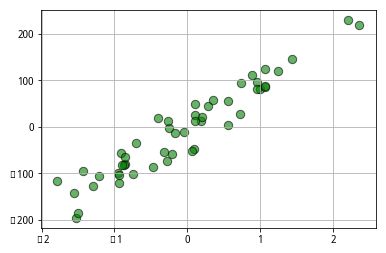

In [2]:
#首先我们使用make_regression生成50个样本
X, y = make_regression(n_samples = 50, 
                       #为了方便画图，设置特征数量为1
                       n_features = 1, 
                       #加大噪音，这里设置为40
                       #读者朋友可以自己调节来观察区别
                       noise = 40,
                       #指定随机状态便于复现
                       #这个数字读者朋友可以随意设置
                      random_state = 88)
#使用matplotlib绘制散点图
plt.scatter(X,y, 
            #设置散点的尺寸为70
            s = 70,
            #设置散点的颜色为green
            c = 'g', 
            #为了便于观察，设置边缘的颜色为black
            edgecolor = 'k', 
            #降低透明度，只是为了美观
            alpha = 0.6)
#添加网格
plt.grid()
#显示图像
plt.show()

In [3]:
#可以查看一下第一个样本的特征值与目标值
print(X[0],y[0])

[-0.2770237835989297] -74.20883782560651


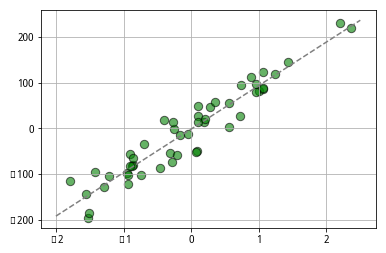

In [4]:
#创建一个线性回归实例
lr = LinearRegression()
#使用样本的特征与目标值训练线性回归模型
lr.fit(X, y)
#为了对模型进行展示，我们生成一些新的数据
#横轴的数值在-2到2.5之间，数量为100个
X_new = np.linspace(-2, 2.5, 100)
#纵轴是模型对这些新数据点作出的预测值
#因为样本只有1个特征，因此要用reshape来处理一下
y_new = lr.predict(X_new.reshape(-1,1))
#把make_regression生成的样本用散点画出来
plt.scatter(X,y, s = 70, c = 'g', edgecolor = 'k', alpha = 0.6)
#用折线图绘制线性回归模型
plt.plot(X_new, y_new, c = 'grey', ls = '--')
#添加网格
plt.grid()
#显示图像
plt.show()

In [5]:
#查看这条直线的斜率与截距
print(lr.coef_, lr.intercept_)

[95.33470141581209] -1.7453511239155963


In [6]:
#样本的特征值是3，用模型预测它的目标值
pre = lr.predict([[3]])
#查看预测值
pre

array([284.25875312352065])

In [7]:
#导入岭回归模型
from sklearn.linear_model import Ridge
#为了让大家看到区别，把alpha值调高至50
ridge = Ridge(alpha = 50)
#使用make_regression生成的样本训练岭回归模型
ridge.fit(X, y)

Ridge(alpha=50, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

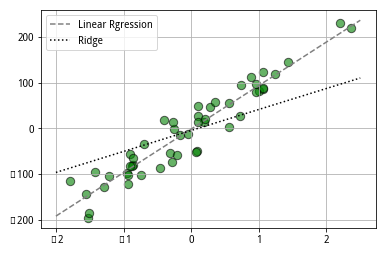

In [8]:
#用岭回归对X_new作出预测
y_new2 = ridge.predict(X_new.reshape(-1,1))
#把make_regression生成的样本用散点画出来
plt.scatter(X,y, s = 70, c = 'g', edgecolor = 'k', alpha = 0.6)
#绘制线性回归模型
plt.plot(X_new, y_new, c = 'grey', ls = '--',label = 'Linear Rgression')
#绘制岭回归模型
plt.plot(X_new, y_new2, c = 'k', ls = ':', label = 'Ridge')
#添加网格
plt.grid()
#添加图注
plt.legend()
#显示图像
plt.show()

7.2 开始搞因子

In [9]:
#导入聚宽数据加载工具
import jqdata

In [10]:
#这回咱们就把上证50成分股作为股票池
stocks = get_index_stocks('000016.XSHG')
#用query函数获取股票的代码
q = query(valuation.code,
          #还有市值
          valuation.market_cap,
          #净资产，用总资产减去总负债
         balance.total_assets - balance.total_liability,
          #再来一个资产负债率的倒数
         balance.total_assets/balance.total_liability,
          #把净利润也考虑进来
         income.net_profit,
          #还有年度收入增长
         indicator.inc_revenue_year_on_year,
          #研发费用
         balance.development_expenditure
         ).filter(valuation.code.in_(stocks))
#将这些数据存入一个数据表中
df = get_fundamentals(q)
#给数据表指定每列的列名称
df.columns = ['code', 
              'mcap', 
              'na', 
              '1/DA ratio', 
              'net income', 
              'growth', 
              'RD']
#检查一下是否成功
df.head()

,code,mcap,na,1/DA ratio,net income,growth,RD
0,600000.XSHG,3061.4221,5.828085e+11,1.086756,1.753000e+10,10.66,NaN
1,600009.XSHG,1321.8936,3.256409e+10,9.664898,1.143673e+08,-41.02,NaN
2,600016.XSHG,2548.1367,5.486401e+11,1.085547,1.681100e+10,12.48,NaN
3,600028.XSHG,5339.2402,8.476660e+11,1.883102,-2.103200e+10,-22.59,NaN
4,600030.XSHG,3046.8411,1.811964e+11,1.244486,4.223257e+09,22.14,NaN


In [11]:
#把股票代码做成数据表的index
df.index = df['code'].values
#然后把原来代码这一列丢弃掉，防止它参与计算
df = df.drop('code', axis = 1)
#把除去市值之外的数据作为特征，赋值给X
X = df.drop('mcap', axis = 1)
#市值这一列作为目标值，赋值给y
y = df['mcap']
#用0来填补数据中的空值
X = X.fillna(0)
y = y.fillna(0)

In [12]:
#使用线性回归来拟合数据
reg = LinearRegression().fit(X,y)
#将模型预测值存入数据表
predict = pd.DataFrame(reg.predict(X), 
                       #保持和y相同的index，也就是股票的代码
                       index = y.index,
                       #设置一个列名，这个根据你个人爱好就好
                       columns = ['predict_mcap'])
#检查是否成功
predict.head()

,predict_mcap
600000.XSHG,4551.781736
600009.XSHG,5588.677394
600016.XSHG,4363.823399
600028.XSHG,3215.071717
600030.XSHG,2087.274051


In [13]:
#使用真实的市值，减去模型预测的市值
diff = df['mcap'] - predict['predict_mcap']
#将两者的差存入一个数据表，index还是用股票的代码
diff = pd.DataFrame(diff, index = y.index, columns = ['diff'])
#将该数据表中的值，按生序进行排列
diff = diff.sort_values(by = 'diff', ascending = True)
#找到市值被低估最多的10只股票
diff.head(10)

,diff
600009.XSHG,-4266.783794
601988.XSHG,-2946.308147
601328.XSHG,-1955.203873
600016.XSHG,-1815.686699
601088.XSHG,-1775.203468
600276.XSHG,-1655.935830
601288.XSHG,-1640.995317
601668.XSHG,-1608.230577
600000.XSHG,-1490.359636
601818.XSHG,-1404.264913
